# Patent applications

This notebook provides different statistics related to patent applications. It is important to note that all the given number refers to granted patent approved by the USPTO (United State Patent and Trademark Office). Therefore the statistics highlighted do not cover all the patent applications all over the world but since the US is the most important patent provider, our study gives an accurate overview of the trend in the world.
Our research aims to compare the evolution of patents application according to different countries, sectors, companies. Thus, the absolute number of patents is less relevent than its evolution over time.

This notebook includes the following studies :

    1) The evolution of granted patents around the world the past 10 years (from 2007 to 2017)
    2) The number of USPTO granted patent by countries
    3) A colorful map highlighting the dispertion of patents around the world
    4) The top companies delivering patents 
    5) The top countries delivering patents by general sectors (CPC)
    7) Radar graphs for the top patents delivered countries
    6) A study of the number of patents delivered for a specific sector (To be continued for the next milestone)
  

In [1]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from implementations import *

In order to manipulate the database, an API is porvided. The latter allows to send queries which always start with the following base URL

**BASE_URL = 'http://www.patentsview.org/api/patents/query?'**

Then it is possible to request a special research according to special key words.
For exemple we could search (keyword q) for all the patents granted after april 2007 and display (keyword f) the patent number and patent granted date :
http://www.patentsview.org/api/patents/query?q={"_gte":{"patent_date":"2007-01-04"}}&f=["patent_number","patent_date"]

### Number of granted patents the past 10 years

This section aims to display the evolution of granted patent from january 2007 to january 2017

The API cannot search for more than 100000 patents in one request. Thus, we need to collect the number of patents by month first and the add them together to get the number of patents in a year.

Display the number of granted patents in a table

In [3]:
years = list(range(2007,2017))
list_nb_patent=[get_nb_patents_year(str(year)) for year in years]
df_nb_patent=pd.DataFrame(index=years)
df_nb_patent['nb_patents']=list_nb_patent
df_nb_patent

,nb_patents
2007,183496
2008,181694
2009,190319
2010,245132
2011,246696
2012,275227
2013,296921
2014,326920
2015,324822
2016,340823


Plot the number of granted patent

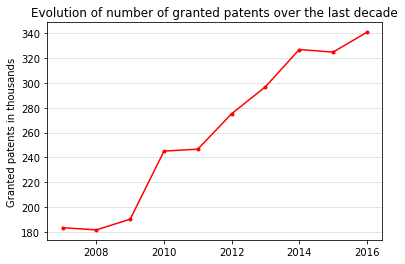

In [4]:
plot(years, df_nb_patent['nb_patents']/1000, 'r', marker= '.')
plt.ylabel('Granted patents in thousands')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Evolution of number of granted patents over the last decade")
plt.show()

### Number of granted patent delivered by countries

This section aims to display which countries are the top patent providers. In a given patent, there are often multiple inventors cited. Those inventors can be located in different countries. In that case, +1 will be counted for a country if at least one of the inventor is in the given country. The number of patents between january 2016 and january 2017 was chosen for this study

First, read the excel file given by the USPTO website which contains all the countries which have delivered patent in the past. Thos countries are coded according to the Alpha-2 ISO norm ("US","GE","FR","CH",...)

In [5]:
dfLocation=pd.read_excel(os.getcwd()+'/location.xlsx').fillna('')

Clean the countries list and keep the Alpha-2 ISO codes only 

In [6]:
countries=list(set(list(dfLocation['country'])))
countries = [countries[i] for i in range(len(countries)) if (len(countries[i]) == 2 and countries[i]!='a"')]

The **get_nb_patent_country** function below returns the number of granted patents for a given country. It might be possible that some countries are big patent provider and that their number of patents exceed 100000 in the year which overwhelms the API capacity. in that case the API request is splited between the 6 first and 6 last months of the year and the number of patents are added together eventually. 

In [7]:
dfNbPatents=pd.DataFrame(columns=['country','nb_patents'])
dfNbPatents['country']=countries
dfNbPatents['nb_patents']=list(map(lambda x: get_nb_patent_country(x),dfNbPatents['country']))

We just created the dataframe containing the patents data grouped by countries.

The number of patents are sorted by country and the barplot is displayed

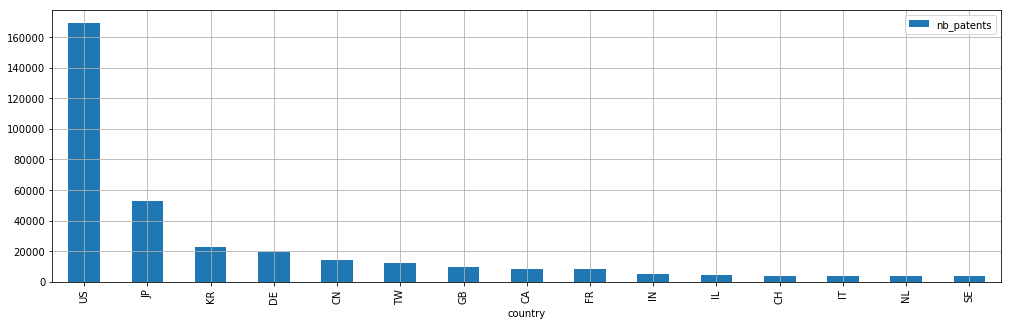

In [8]:
dfNbPatents.sort_values(by='nb_patents',inplace=True, ascending=False)
dfNbPatents.head(15).plot.bar(x='country', y='nb_patents', figsize=(17,5), grid=True)

Display the exact number for the 10 top patent delivered countries

In [9]:
dfNbPatents.set_index(pd.Series(list(range(1,len(dfNbPatents) + 1))), inplace=True)
dfNbPatents.head(10)

,country,nb_patents
1,US,169052
2,JP,53175
3,KR,22593
4,DE,19859
5,CN,14044
6,TW,12378
7,GB,9441
8,CA,8742
9,FR,8315
10,IN,5279


### Colorful map of the granted patent dispersion


This section aims to display a vizual world map which highlight the granted patent dispersion by countries 

As there is a very large gap between the number of patents throughout the different countries, we opted for a logarithmic scale for a better vizualisation. Without loss of generality, we shall still be able to vizualize accurate relative differences between numbers.   

In [10]:
max_n = dfNbPatents['nb_patents'] 

#169052 is the larger number of patents (delivered by the US) 
colormap = cm.linear.PuBu.scale(0, round(math.log(169052))).to_step(100)

In [11]:
patents = dfNbPatents.copy()
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , patents['nb_patents']))
log_nb
patents['log_color_code'] = log_nb
patents.head()

,country,nb_patents,log_color_code
1,US,169052,12.037962
2,JP,53175,10.881344
3,KR,22593,10.025395
4,DE,19859,9.896413
5,CN,14044,9.549951


In [12]:
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = patents.set_index('country')['log_color_code']

#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

This functions applies the color to the countries, that were previously stored in **color_dict**.
In case a country does not appear in the list of patents, we assign the white color by default.

We can now draw a chloropleth map that shows the number of patents around the world.

In [13]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = 'custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

#Setting up the scale 
colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('world.html')

Here is an overview of the world distribution of the number of patents 

![Image](world_patent.png)

**The interactive map can be accessed [here](https://skagankose.github.io/ada_fall_2017/world.html).**

##  LINK to the MAP


In [14]:
# GET PATENTS GRANTED ON MARCH OF 2010
patent_json = get_patents(2010, 2, 2010, 3)
patente_df = pd.DataFrame(patent_json['patents'])

In [15]:
patente_df.head()

,patent_id,patent_number,patent_title
0,7653948,7653948,Massaging clothing
1,7653949,7653949,Mitten-sleeve combination for a winter garment
2,7653950,7653950,Stiffening device for apparel
3,7653951,7653951,Flushing device comprising a pressurized chamb...
4,7653952,7653952,Bed with movable mattress


### GRANTED VS PENDING

Upon our initial examinations, we observe that there is information about patent applications and therefore, we though that we can analyze applications that are not granted yet. But as we dıg deeper we found out that ınfomatıon about patent applıcatıons are only present for granted patents and consequently, it is not possible to derive pending patent application from the dataset.

### TOP COMPANIES


In [16]:
# DATAFRAME OF COMPANY AND TOTAL PATENT COUNT
company_patent_df = pd.DataFrame(list(get_company(2017, 1, 2017, 5).items()))

# REMOVE NONE
company_patent_df.dropna(inplace=True)

# CHANGE COLUMN NAMES
company_patent_df.columns = ['company', 'total_patent']

# CONVERT TO INTEGER
company_patent_df.total_patent = company_patent_df.total_patent.astype('int64', copy=False)

# SORT
top_companies_df = company_patent_df.sort_values(by='total_patent', ascending=False)

In [17]:
top_companies_df.head()

,company,total_patent
10,International Business Machines Corporation,111916
115,"Samsung Electronics Co., Ltd.",72139
639,Canon Kabushiki Kaisha,65779
785,Sony Corporation,47267
455,Kabushikikaisha Toshiba,46384


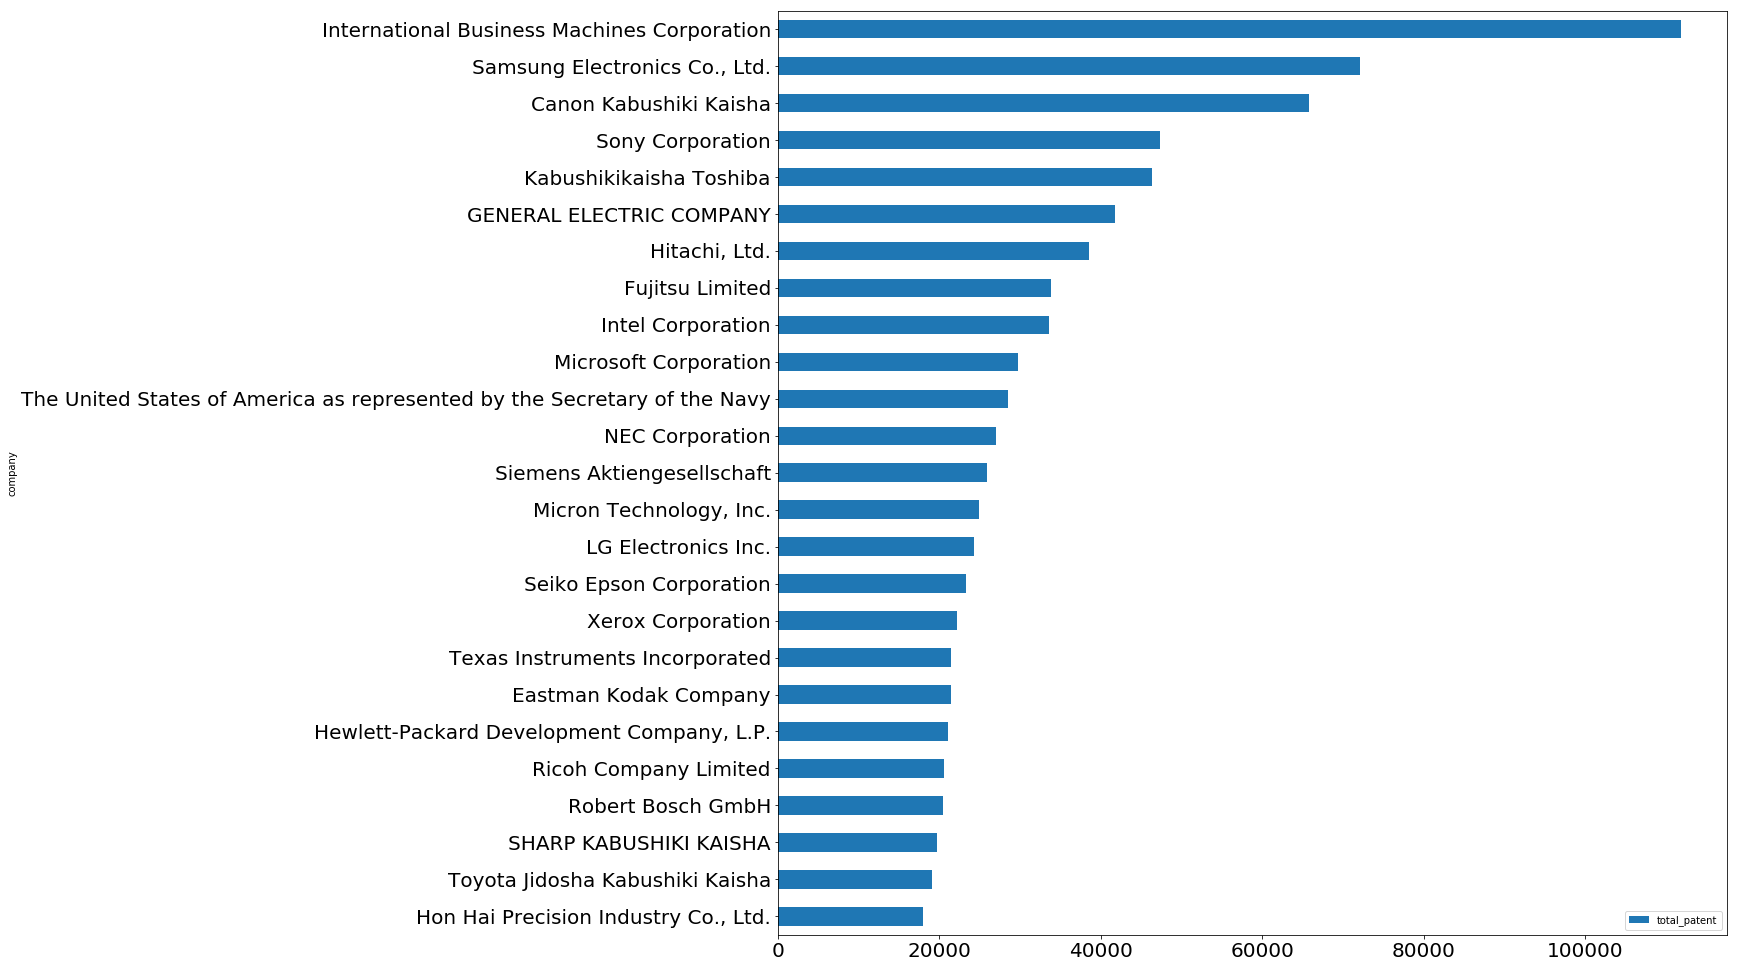

In [18]:
top_companies_df.head(25).plot.barh(x='company', y='total_patent', figsize=(17,17), fontsize=20).invert_yaxis()

### Patents by countries and sectors

`The Cooperative Patent Classification (CPC) is a patent classification system, which has been jointly developed by the European Patent Office (EPO) and the United States Patent and Trademark Office (USPTO).`

`Patent categories according to CPC is indicated in the following table. We've used these categories for our initial analysis.` 

| **CODE** | **DESCRIPTION**   |
|------|------|
|   **A**  | **Human Necessities**|
|   **B**  | **Operations and Transport**|
|   **C**  | **Chemistry and Metallurgy**|
|   **D**  | **Textiles**|
|   **E**  | **Fixed Constructions**|
|   **F**  | **Mechanical Engineering**|
|   **G**  | **Physics**|
|   **H**  | **Electricity**|
|   **Y**  | **Emerging Cross-Sectional Technologies**|

In [19]:
# INITIALIZE COUNTRY
country_abbrev = list(pd.read_csv('data/countries.csv')['alpha-2'])
country_total_patent_category = dict()
for abbrev in country_abbrev:
    country_total_patent_category[abbrev] = {"A":0,"B":0,"C":0,"D":0,"E":0,"F":0,"G":0,"H":0,"Y":0,}

In [20]:
country_total_patent_category = get_countries_by_sectors()

In [21]:
# DATAFRAME OF COUNTRY AND TOTAL PATENT COUNT IN SECTORS
patent_category_df = pd.DataFrame(country_total_patent_category).transpose()

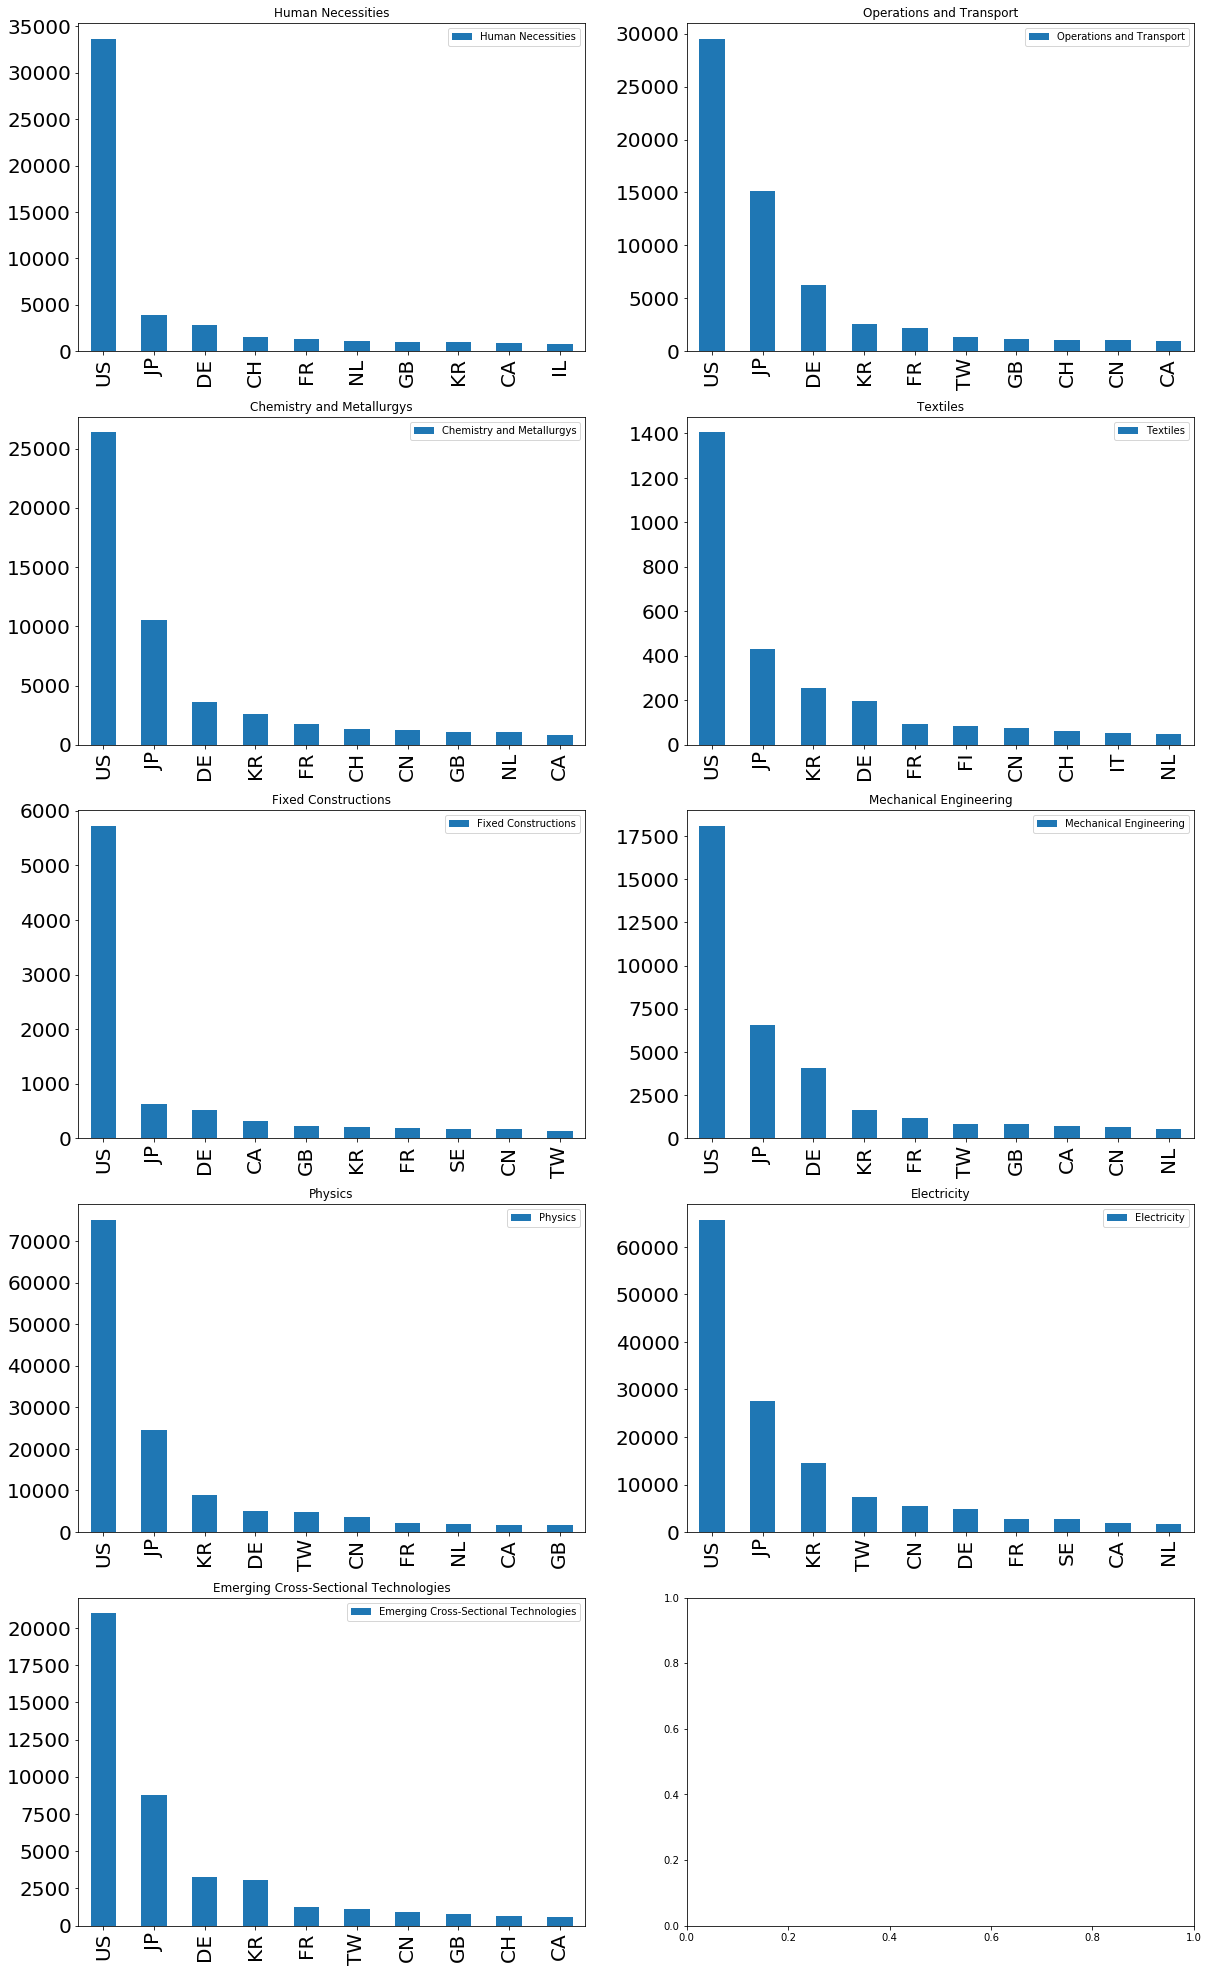

In [22]:
# PLOT TOP 10 COUNTRIES IN EACH SECTOR
def fıgure_by_sector(category, label, fig_index):
    top_countries_df = patent_category_df.sort_values(by=category, ascending=False)
    top_countries_df.head(10).plot.bar(y=category, figsize=(9,7), fontsize=20, subplots=True, ax=axes[fig_index[0], fig_index[1]], label=label)

category_label = [('A', 'Human Necessities'),('B', 'Operations and Transport'),('C', 'Chemistry and Metallurgys'),\
                  ('D', 'Textiles'), ('E', 'Fixed Constructions'),('F', 'Mechanical Engineering'),\
                  ('G', 'Physics'),('H', 'Electricity'),('Y', 'Emerging Cross-Sectional Technologies'),]
    
fix, axes = plt.subplots(5, 2, figsize=(20, 35))
for index, (category, label) in enumerate(category_label):
    fıgure_by_sector(category, label, (int(index/2), index%2))

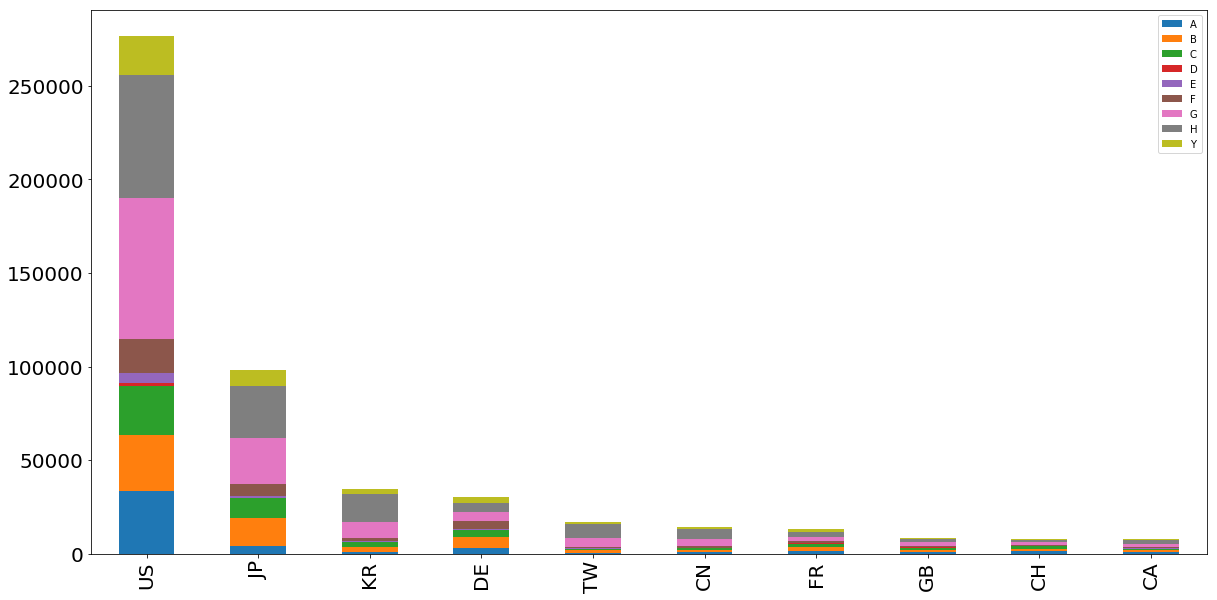

In [23]:
# PLOT TOP 10 COUNTRIES WITH STACKED BAR CHARTS
patent_category_df['total'] = patent_category_df.apply(sum, axis=1)
clean_df = patent_category_df.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,10));

`As it is seen United States is the top country in all sectors. Japan also has huge number of patents. The rest of the countries are Germany (DE), South Korea (KR), Taiwan (TW), France (FR), Netherlands (NL), Switzerland (CH), China (CN), United Kingdom (GB).`

### Radar graphs by sector

In [24]:
def sortby(col):
    return cat_patent.sort_values(by=col, ascending=False)

In [25]:
cat_patent = pd.DataFrame(country_total_patent_category).transpose()
sortby('A').head()

,A,B,C,D,E,F,G,H,Y
US,33672.0,29529.0,26365.0,1405.0,5722.0,18081.0,75174.0,65754.0,20987.0
JP,3918.0,15127.0,10491.0,432.0,638.0,6556.0,24593.0,27602.0,8762.0
DE,2767.0,6205.0,3649.0,197.0,518.0,4048.0,5038.0,4863.0,3255.0
CH,1548.0,1089.0,1309.0,60.0,107.0,540.0,1522.0,1118.0,629.0
FR,1353.0,2223.0,1793.0,95.0,184.0,1172.0,2252.0,2652.0,1258.0


In [26]:
def draw_radar_graph(df, index, title=''):
    labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y'])
    labels_ = np.array(['Human Necessities', 'Transport', 'Chemistry',\
                       'Textiles', 'Constructions', 'MechEng',\
                       'Physics', 'Electricity', 'Cross-Sectional Technologies'])

    stats = df.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    
    fig= plt.figure()
    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    ax.plot(angles, stats, 'o-', linewidth=2, color='r')  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25, color='r')  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, labels_)  # Set the label for each axis
    ax.set_title(title)
    return ax

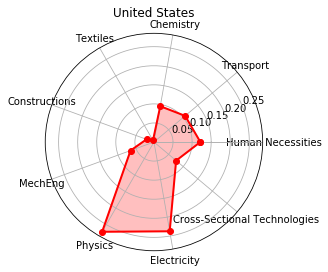

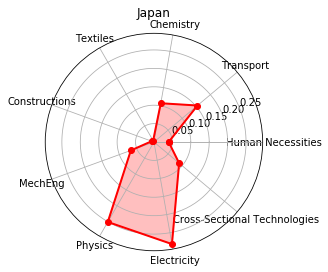

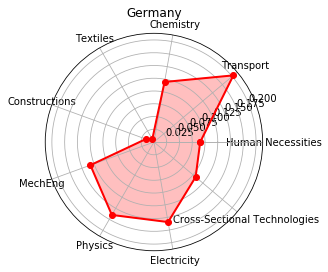

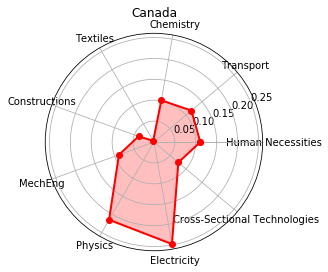

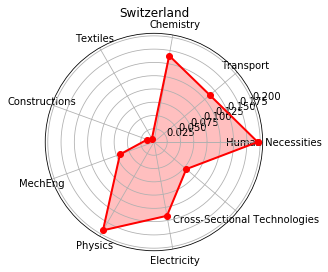

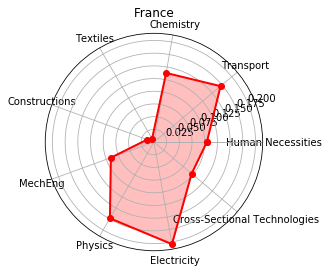

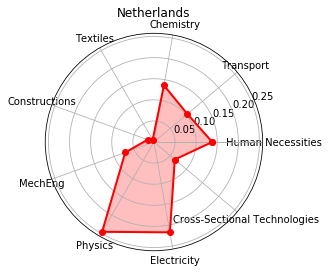

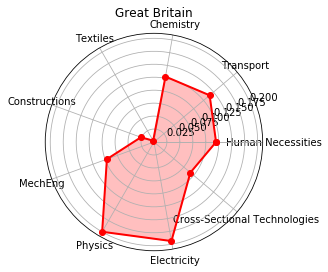

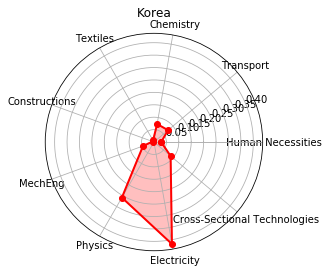

In [27]:
top_countries = patents[:15].index.tolist()
sub = ['00','01','10','11','20','21','30','31','40','41']

a = sortby('A').head(15)
a = a.apply(lambda x: x/sum(x), axis=1)

model_countries = [('US', 'United States'),('JP', 'Japan'), ('DE','Germany'), ('CA','Canada'),\
                   ('CH', 'Switzerland'), ('FR','France'), ('NL','Netherlands'), \
                   ('GB','Great Britain'), ('KR', 'Korea')]



for i in range(len(model_countries)):
    draw_radar_graph(a, model_countries[i][0], title= model_countries[i][1])

### Evolution of granted patents for a given sector

This last part aims to study the evolution of granted patents per sector of interest. This section will be done mostly for milestone 3.

As a brief overview, the evolution of patents in solar energy was carried out. This study will be usefull for comparisons between different technology in energy.

The keywords used are given in the paper "patent-based Technology report - Alternative Energy Technology" made by the "World Intellectual Property Organization" which gives a fairly accurate result for a given technology. The keywords are used to search for a match in the patent titles.  

In [28]:
Keywords_Solar_Power= ["solar cell", "solar-cell","photovoltaic", "solar photo", "PV sun", "light cell",
"panel module"] 

The following function returns the number of patents in a given year according to a list of key words at a given year.

This function also returns a dataframe containing 25 samples maximum of every patent related to a keyword (for checking sake)

In [29]:
list_patent_nb_solar=[]
years= range(2007,2017)
for i in years:
    [dfPatent, nb_patent]=get_patents_keywords(Keywords_Solar_Power,str(i))
    list_patent_nb_solar+=[nb_patent]

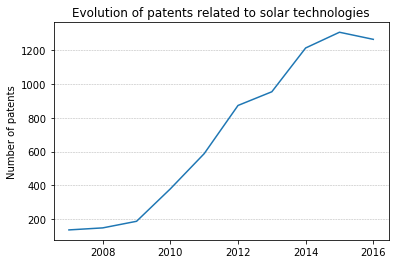

In [30]:
plt.plot(years,list_patent_nb_solar)
plt.ylabel('Number of patents')
plt.title('Evolution of patents related to solar technologies')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

The evolution of granted patent in solar energy can be compared with the evolution of granted patent in general for the past 10 years. In order to achieve this pupose, we can compute an average growth of both patent types

In [31]:
growth_solar=[]
growth=[]
list_nb_patent=list(df_nb_patent['nb_patents'])
for i in range(len(years)-1):
    growth_solar+=[(list_patent_nb_solar[i+1]-list_patent_nb_solar[i])/list_patent_nb_solar[i]*100]
    growth+=[(list_nb_patent[i+1]-list_nb_patent[i])/list_nb_patent[i]*100]

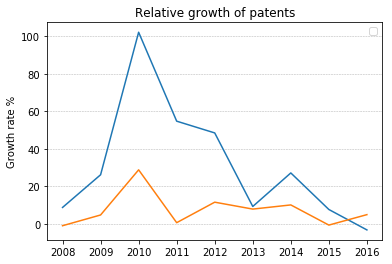

In [32]:
plt.plot(range(2008,2017),growth_solar,range(2008,2017),growth)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Relative growth of patents")
plt.legend("solar energy patents","general patents")
plt.ylabel('Growth rate %')
plt.show()

**The blue graph represents the growth of the solar panel related patents, and in orange the growth of patents in general**